In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import RidgeCV, LinearRegression


In [2]:
data = pd.read_csv('diabetes.txt', sep = " ")
data.head()

,age,sex,bmi,map,tc,ldl,hdl,tch,ltg,glu,y
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,206
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,135


In [3]:
# Define X and Y arrays
X = data.iloc[:,:data.shape[1]-1]
Y = data.iloc[:,data.shape[1]-1].to_numpy()

In [29]:
# We center the Y
Y_tilde = Y - Y.mean(axis=0)
Y = Y - Y.mean(axis=0)

In [30]:
N, p = X.shape

XtX = X.T @ X
XtX_inv = np.linalg.inv(XtX)
XtY = X.T @ Y

I = np.eye(p)

# OLS
beta_hat = XtX_inv @ XtY
resid = Y - X @ beta_hat
RSS = resid.T @ resid
sigma2_ols = RSS / (N - p)


In [31]:
alphas = np.logspace(-4, 4, 100)

ridge_cv = RidgeCV(alphas=alphas, store_cv_values=False)
ridge_cv.fit(X, Y)

lambda_cv = ridge_cv.alpha_
ridge_coef = ridge_cv.coef_


c:\Users\karth\miniconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_ridge.py:2385: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(


In [32]:
# Weak
a_weak = 1e-3
b_weak = 1e-3

# Safe empirical Bayes
a_safe = 2
b_safe = sigma2_ols


In [33]:
# Ridge prior
Sigma_ridge = (1 / lambda_cv) * I

# g prior
g = N
Sigma_g = g * XtX_inv


In [34]:
def bayesian_ridge_posterior(X, y, Sigma, a, b):

    N, p = X.shape

    XtX = X.T @ X
    XtX_inv = np.linalg.inv(XtX)
    XtY = X.T @ y

    beta_hat = XtX_inv @ XtY
    resid = y - X @ beta_hat
    s2 = resid.T @ resid

    Sigma_inv = np.linalg.inv(Sigma)

    A = Sigma_inv + XtX
    A_inv = np.linalg.inv(A)

    beta_post = A_inv @ XtY

    scale = (2*b + s2 + beta_hat.T @ 
             np.linalg.inv(Sigma + XtX_inv) @ beta_hat) / (N + 2*a)

    Sigma_post = scale * A_inv

    return beta_post, Sigma_post


In [35]:
configs = {
    "Weak + Ridge Prior": (Sigma_ridge, a_weak, b_weak),
    "Weak + g Prior": (Sigma_g, a_weak, b_weak),
    "Safe + Ridge Prior": (Sigma_ridge, a_safe, b_safe),
    "Safe + g Prior": (Sigma_g, a_safe, b_safe),
}

results = {}

for name, (Sigma, a, b) in configs.items():

    beta_post, Sigma_post = bayesian_ridge_posterior(X, Y, Sigma, a, b)

    se = np.sqrt(np.diag(Sigma_post))

    results[name] = {
        "mean": beta_post,
        "low": beta_post - 1.96 * se,
        "high": beta_post + 1.96 * se
    }


In [37]:
variables = [f"X{i}" for i in range(p)]

df = pd.DataFrame({
    "Variable": variables,
    "Ridge_CV": ridge_coef
})

for k in results:
    df[k] = results[k]["mean"]
    df[k+"_low"] = results[k]["low"]
    df[k+"_high"] = results[k]["high"]


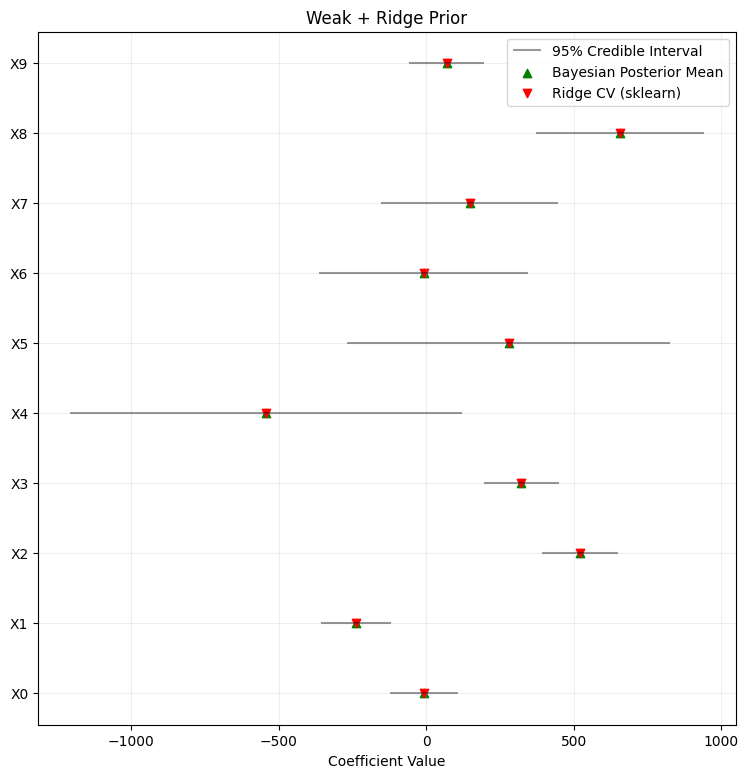

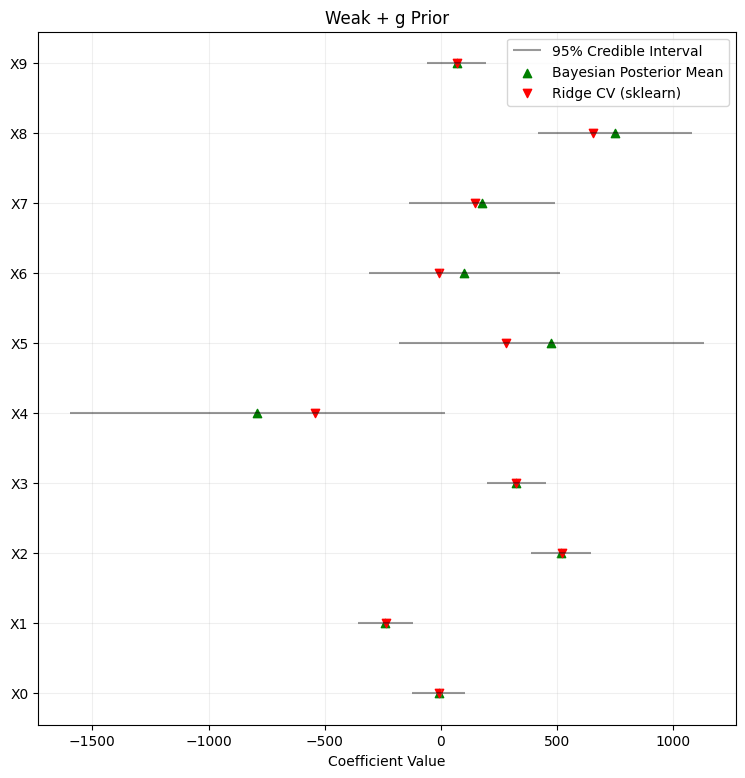

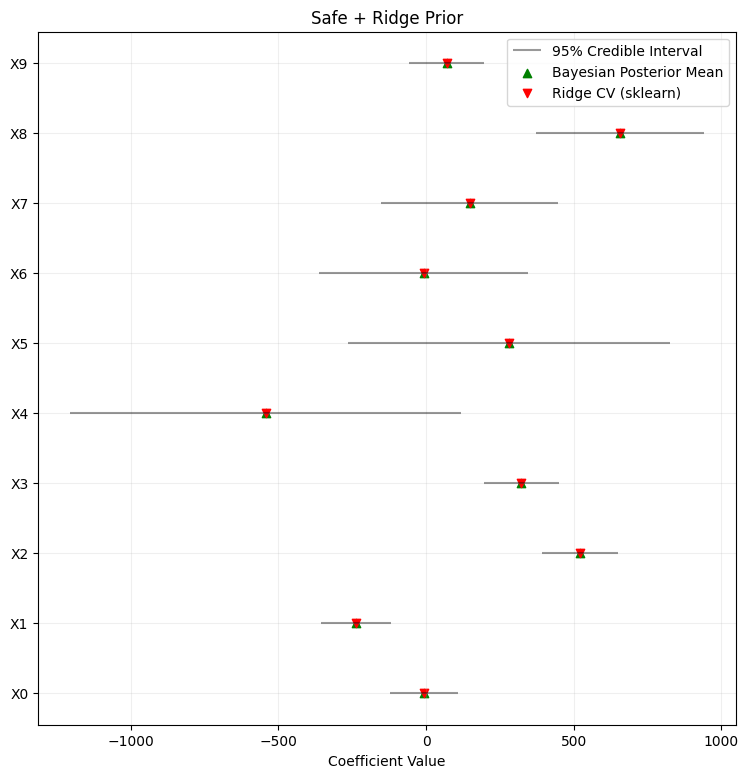

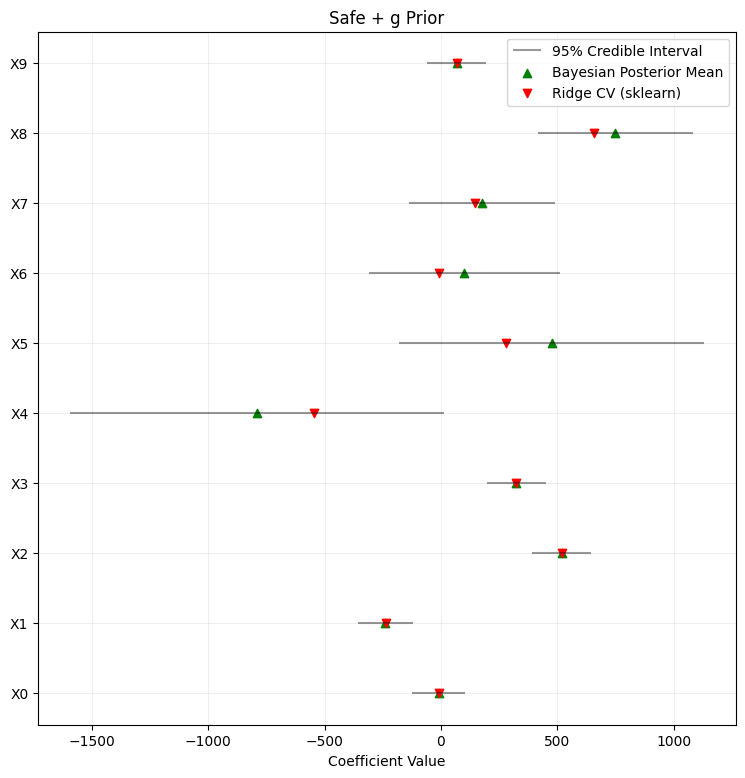

In [38]:
import seaborn as sns

for config_name in results.keys():

    plt.figure(figsize=(9,9))

    y_pos = np.arange(p)

    # Credible intervals
    plt.hlines(
        y=y_pos,
        xmin=df[config_name+"_low"],
        xmax=df[config_name+"_high"],
        color='black',
        alpha=0.4,
        label='95% Credible Interval'
    )

    # Bayesian mean
    plt.scatter(
        df[config_name],
        y_pos,
        color='green',
        marker='^',
        label='Bayesian Posterior Mean'
    )

    # Ridge CV baseline
    plt.scatter(
        df["Ridge_CV"],
        y_pos,
        color='red',
        marker='v',
        label='Ridge CV (sklearn)'
    )

    plt.yticks(y_pos, df["Variable"])
    plt.xlabel("Coefficient Value")
    plt.title(config_name)
    plt.legend()
    plt.grid(alpha=0.2)

    plt.show()
